In [1]:
import MySQLdb as mys
import pandas as pd

print "Connecting to database..."
db = mys.connect(host='localhost', user='root', db="praneetha_example")

df = pd.read_sql('SELECT * FROM zikachart', db)

df.head()

Connecting to database...


,report_date,location,location_type,data_field,data_field_code,time_period,time_period_type,value,unit
0,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_local_cases,AR0001,NA,NA,0,cases
1,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_local_cases,AR0002,NA,NA,0,cases
2,2016-03-19,Argentina-Buenos_Aires,province,cumulative_confirmed_imported_cases,AR0003,NA,NA,2,cases
3,2016-03-19,Argentina-Buenos_Aires,province,cumulative_probable_imported_cases,AR0004,NA,NA,1,cases
4,2016-03-19,Argentina-Buenos_Aires,province,cumulative_cases_under_study,AR0005,NA,NA,127,cases


In [2]:
max_date = """SELECT report_date, location, data_field_code, value FROM zikachart 
WHERE (report_date, location) IN (SELECT MAX(report_date), location FROM zikachart GROUP BY location)"""

df2 = pd.read_sql(max_date, db)

df2.head()

,report_date,location,data_field_code,value
0,2016-06-26,Argentina-Buenos_Aires,AR0001,0
1,2016-06-26,Argentina-Buenos_Aires,AR0002,0
2,2016-06-26,Argentina-Buenos_Aires,AR0003,2
3,2016-06-26,Argentina-Buenos_Aires,AR0004,2
4,2016-06-26,Argentina-Buenos_Aires,AR0005,223


In [3]:
confirmed_codes = open('ConfirmedZikaCodes.txt', 'r')

def combine_total_vals(place):
    if '-' in place:
        return place.split('-')[0]
    else:
        return place

def code_reader(text_file):
    code_df = """(SELECT report_date, location, data_field_code, value FROM (""" + max_date + """) 
    AS max_date WHERE 1=0)"""

    for line in text_file:
        country, other = line.split('=')
        if ':' in other:
            codes = other.split(':')[0].split(',')
            for c in codes:
                code_df = code_df + """ UNION (SELECT report_date, location, data_field_code, value 
                FROM (""" + max_date + """) AS max_date WHERE data_field_code = '""" + c.strip() + """' 
                GROUP BY location)"""
        else:
            if ',' in other: codes = other.split(',') 
            else: codes = [other]
            for c in codes:
                code_df = code_df + """ UNION (SELECT report_date, location, data_field_code, value 
                FROM (""" + max_date + """) AS max_date WHERE data_field_code = '""" + c.strip() + """' 
                AND location = '""" + country + """')"""

    print "Reading SQL statement..."
    code_pd = pd.read_sql(code_df, db)
    code_pd['country'] = code_pd['location'].apply(combine_total_vals)
    return code_pd

conf_pd = code_reader(confirmed_codes)
conf_pd.loc[conf_pd['location'] == 'Argentina-Buenos_Aires'].head()

Reading SQL statement...


,report_date,location,data_field_code,value,country
0,2016-06-26,Argentina-Buenos_Aires,AR0001,0,Argentina
24,2016-06-26,Argentina-Buenos_Aires,AR0003,2,Argentina


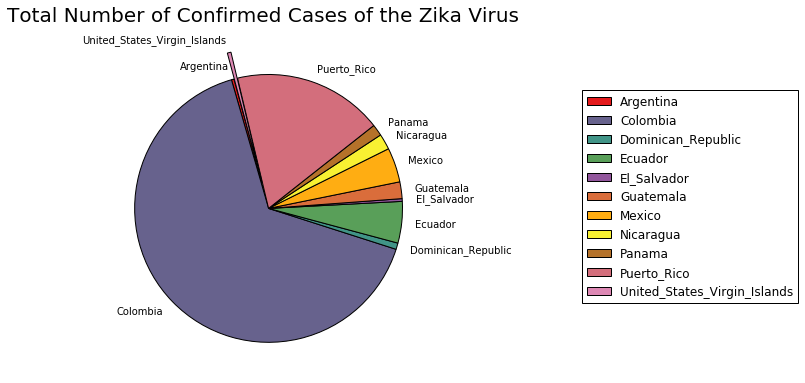

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

%matplotlib inline


sums1 = conf_pd.value.groupby(conf_pd.country).sum()
plt.pie(sums1, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2), labels=sums1.index, \
        startangle=105, colors = cm.Set1(np.arange(11)/11.));
plt.legend(sums1.index,loc='lower right', bbox_to_anchor=(2.1, 0.2))

fig = plt.gcf()
fig.suptitle("Total Number of Confirmed Cases of the Zika Virus", fontsize = 20)
fig.set_size_inches(6,6)

plt.show()


In [5]:
suspected_codes = open('SuspectedZikaCodes.txt', 'r')

susp_pd = code_reader(suspected_codes)
susp_pd.loc[susp_pd['location'] == 'Argentina-Buenos_Aires'].head()

Reading SQL statement...


,report_date,location,data_field_code,value,country
0,2016-06-26,Argentina-Buenos_Aires,AR0002,0,Argentina
24,2016-06-26,Argentina-Buenos_Aires,AR0004,2,Argentina
48,2016-06-26,Argentina-Buenos_Aires,AR0005,223,Argentina
72,2016-06-26,Argentina-Buenos_Aires,AR0006,25,Argentina


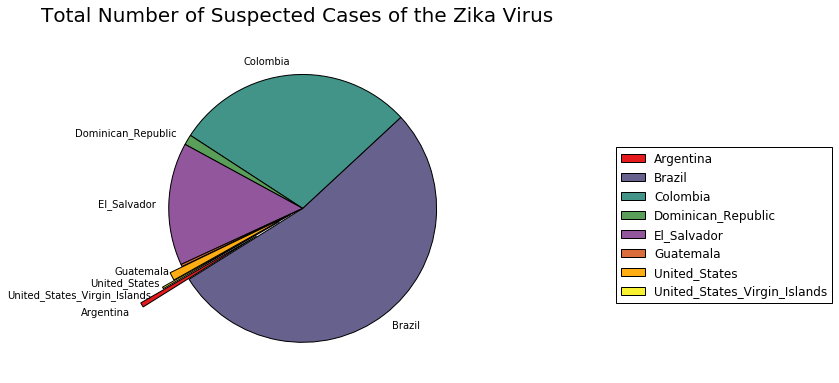

In [6]:
sums2 = susp_pd.value.groupby(susp_pd.country).sum()
plt.pie(sums2, explode=(0.4, 0, 0, 0, 0, 0, 0.1, 0.2),labels=sums2.index, \
        startangle=-150, colors = cm.Set1(np.arange(11)/11.));
plt.legend(loc='lower right', bbox_to_anchor=(2.1, 0.2))

fig = plt.gcf()
fig.suptitle("Total Number of Suspected Cases of the Zika Virus", fontsize = 20)
fig.set_size_inches(6,6)

plt.show()

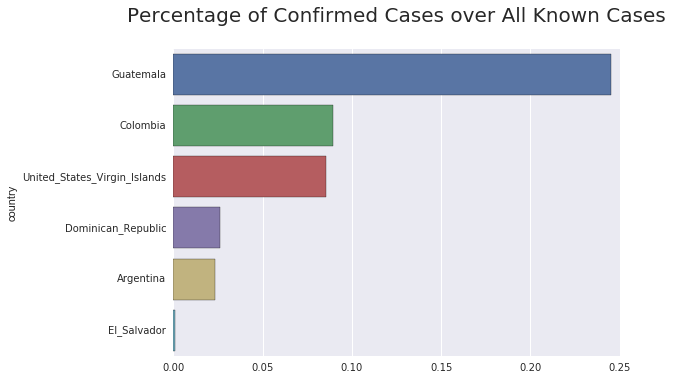

In [7]:
import seaborn as sns

sum_percents = (sums1/(sums1+sums2)).dropna()
sum_percents.sort(ascending=False)

sns.plt.title('Percentage of Confirmed Cases over All Known Cases\n', fontsize=20)
sns.barplot(x=sum_percents, y=sum_percents.index)